In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
def convert_data_to_tensors(data, word_vectors):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            if word in word_vectors:
                embedding.append(word_vectors[word])
            else:
                embedding.append([0] * len(word_vectors['hello']))  # Use a zero vector for unknown words
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len =70
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(word_vectors['hello'])] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [5]:
x_train = convert_data_to_tensors(train_data, word_vectors)
x_val = convert_data_to_tensors(val_data, word_vectors)
x_test = convert_data_to_tensors(test_data, word_vectors)

/tmp/ipykernel_52736/4138626256.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [6]:
x_train.size()

torch.Size([8019, 70, 300])

In [7]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([8019, 70])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_52736/1893452685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_52736/1893452685.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_52736/1893452685.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_52736/1893452685.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/130, Train Loss: 1.2130774183878823, Val Loss: 0.8986592888832092, Val F1: 0.033853652614183063, Train F1: 0.03331073876649098


  2%|▋                                          | 2/130 [00:02<03:06,  1.46s/it]

Epoch 2/130, Train Loss: 0.8482191657263135, Val Loss: 0.7632544040679932, Val F1: 0.03428809126456513, Train F1: 0.034207952796164495


  2%|▉                                          | 3/130 [00:04<02:58,  1.40s/it]

Epoch 3/130, Train Loss: 0.7287942521155827, Val Loss: 0.6851793527603149, Val F1: 0.06971200549799252, Train F1: 0.05189619980662463


  3%|█▎                                         | 4/130 [00:05<02:52,  1.37s/it]

Epoch 4/130, Train Loss: 0.652823805809021, Val Loss: 0.6073424220085144, Val F1: 0.09766986380015984, Train F1: 0.07858308487281451


  4%|█▋                                         | 5/130 [00:06<02:48,  1.35s/it]

Epoch 5/130, Train Loss: 0.5868225414601583, Val Loss: 0.5500441193580627, Val F1: 0.1536989446926956, Train F1: 0.12137415887354852


  5%|█▉                                         | 6/130 [00:08<02:47,  1.35s/it]

Epoch 6/130, Train Loss: 0.5377505241878449, Val Loss: 0.5162631869316101, Val F1: 0.19886112236588258, Train F1: 0.1655780283893166


  5%|██▎                                        | 7/130 [00:09<02:44,  1.34s/it]

Epoch 7/130, Train Loss: 0.5058615931442806, Val Loss: 0.4897676110267639, Val F1: 0.20208633023258218, Train F1: 0.19297032171676706


  6%|██▋                                        | 8/130 [00:10<02:42,  1.33s/it]

Epoch 8/130, Train Loss: 0.4847132880536337, Val Loss: 0.46591588854789734, Val F1: 0.21389583924276878, Train F1: 0.20970369865937358


  7%|██▉                                        | 9/130 [00:12<02:40,  1.33s/it]

Epoch 9/130, Train Loss: 0.46745138130490743, Val Loss: 0.4527304768562317, Val F1: 0.23429365973558877, Train F1: 0.22518330838579795


  8%|███▏                                      | 10/130 [00:13<02:38,  1.32s/it]

Epoch 10/130, Train Loss: 0.4526049499473875, Val Loss: 0.4422585368156433, Val F1: 0.2444147616579576, Train F1: 0.23890115077344856


  8%|███▌                                      | 11/130 [00:14<02:37,  1.32s/it]

Epoch 11/130, Train Loss: 0.4436576290736123, Val Loss: 0.4355296492576599, Val F1: 0.2554385996992965, Train F1: 0.247643542534473


  9%|███▉                                      | 12/130 [00:16<02:36,  1.32s/it]

Epoch 12/130, Train Loss: 0.433749095315025, Val Loss: 0.43093302845954895, Val F1: 0.2529172796385809, Train F1: 0.2573932456618988


 10%|████▏                                     | 13/130 [00:17<02:37,  1.35s/it]

Epoch 13/130, Train Loss: 0.42646830659064033, Val Loss: 0.4356442093849182, Val F1: 0.24959446428246515, Train F1: 0.26675014850670764


 11%|████▌                                     | 14/130 [00:18<02:36,  1.35s/it]

Epoch 14/130, Train Loss: 0.42096230293077136, Val Loss: 0.4220408499240875, Val F1: 0.26054471762131753, Train F1: 0.27408601177748304


 12%|████▊                                     | 15/130 [00:20<02:35,  1.35s/it]

Epoch 15/130, Train Loss: 0.4154911344013517, Val Loss: 0.4184004068374634, Val F1: 0.27611824754775705, Train F1: 0.275542445011757


 12%|█████▏                                    | 16/130 [00:21<02:36,  1.37s/it]

Epoch 16/130, Train Loss: 0.4105997903952523, Val Loss: 0.414420485496521, Val F1: 0.28274212694407275, Train F1: 0.2875027032832634


 13%|█████▍                                    | 17/130 [00:23<02:33,  1.36s/it]

Epoch 17/130, Train Loss: 0.4037036881560371, Val Loss: 0.4118651747703552, Val F1: 0.2879671899057618, Train F1: 0.29609152132152894


 14%|█████▊                                    | 18/130 [00:24<02:31,  1.35s/it]

Epoch 18/130, Train Loss: 0.4016174134753999, Val Loss: 0.411655455827713, Val F1: 0.29762248101926875, Train F1: 0.3036564352961087


 15%|██████▏                                   | 19/130 [00:25<02:29,  1.34s/it]

Epoch 19/130, Train Loss: 0.39529677752464537, Val Loss: 0.40660369396209717, Val F1: 0.2935437988324983, Train F1: 0.3146390875211808


 15%|██████▍                                   | 20/130 [00:26<02:27,  1.34s/it]

Epoch 20/130, Train Loss: 0.39127126809150453, Val Loss: 0.4031400978565216, Val F1: 0.3038285962067709, Train F1: 0.31961098178162367


 16%|██████▊                                   | 21/130 [00:28<02:25,  1.34s/it]

Epoch 21/130, Train Loss: 0.3880471889934843, Val Loss: 0.4057229459285736, Val F1: 0.3329869615262457, Train F1: 0.3253718187065819


 17%|███████                                   | 22/130 [00:29<02:24,  1.33s/it]

Epoch 22/130, Train Loss: 0.3860539968997713, Val Loss: 0.40806546807289124, Val F1: 0.3169632281287463, Train F1: 0.33330013919428586


 18%|███████▍                                  | 23/130 [00:30<02:22,  1.34s/it]

Epoch 23/130, Train Loss: 0.38243253552724443, Val Loss: 0.3976951539516449, Val F1: 0.3377585565870575, Train F1: 0.3374514820181385


 18%|███████▊                                  | 24/130 [00:32<02:26,  1.38s/it]

Epoch 24/130, Train Loss: 0.37798146974472774, Val Loss: 0.3996950089931488, Val F1: 0.3240881888720562, Train F1: 0.3466331618381885


 19%|████████                                  | 25/130 [00:33<02:25,  1.38s/it]

Epoch 25/130, Train Loss: 0.3754808987889971, Val Loss: 0.3997093737125397, Val F1: 0.3508940928524417, Train F1: 0.3477380044124732


 20%|████████▍                                 | 26/130 [00:35<02:22,  1.37s/it]

Epoch 26/130, Train Loss: 0.37066467981489876, Val Loss: 0.3942767083644867, Val F1: 0.34524066001404446, Train F1: 0.3554720982569124


 21%|████████▋                                 | 27/130 [00:36<02:20,  1.36s/it]

Epoch 27/130, Train Loss: 0.3686910181764572, Val Loss: 0.39653632044792175, Val F1: 0.34904041465855434, Train F1: 0.36016722671667967


 22%|█████████                                 | 28/130 [00:37<02:17,  1.35s/it]

Epoch 28/130, Train Loss: 0.3652030475555904, Val Loss: 0.3936768174171448, Val F1: 0.35976004849504195, Train F1: 0.36189081291080344


 22%|█████████▎                                | 29/130 [00:39<02:15,  1.34s/it]

Epoch 29/130, Train Loss: 0.36182381283669246, Val Loss: 0.39815375208854675, Val F1: 0.35054746423777444, Train F1: 0.37133426983120527


 23%|█████████▋                                | 30/130 [00:40<02:13,  1.33s/it]

Epoch 30/130, Train Loss: 0.3589189156653389, Val Loss: 0.39149197936058044, Val F1: 0.3676822583978293, Train F1: 0.3725143172855759


 24%|██████████                                | 31/130 [00:41<02:11,  1.33s/it]

Epoch 31/130, Train Loss: 0.3555203288320511, Val Loss: 0.39959701895713806, Val F1: 0.3611130415048154, Train F1: 0.37538384372048833


 25%|██████████▎                               | 32/130 [00:43<02:10,  1.33s/it]

Epoch 32/130, Train Loss: 0.3541852382440416, Val Loss: 0.3923381268978119, Val F1: 0.36458668581900777, Train F1: 0.37913864345431153


 25%|██████████▋                               | 33/130 [00:44<02:08,  1.32s/it]

Epoch 33/130, Train Loss: 0.35105491677920025, Val Loss: 0.3901337683200836, Val F1: 0.364164039946692, Train F1: 0.3899724309794101


 26%|██████████▉                               | 34/130 [00:45<02:07,  1.32s/it]

Epoch 34/130, Train Loss: 0.3492609678752839, Val Loss: 0.39187923073768616, Val F1: 0.35366336286992567, Train F1: 0.38874398450989


 27%|███████████▎                              | 35/130 [00:47<02:08,  1.35s/it]

Epoch 35/130, Train Loss: 0.35638084250783164, Val Loss: 0.3897678852081299, Val F1: 0.37662103823315585, Train F1: 0.38635409917017277


 28%|███████████▋                              | 36/130 [00:48<02:06,  1.34s/it]

Epoch 36/130, Train Loss: 0.34627493127943976, Val Loss: 0.3891140818595886, Val F1: 0.3695262798246323, Train F1: 0.3918324481782276


 28%|███████████▉                              | 37/130 [00:49<02:04,  1.34s/it]

Epoch 37/130, Train Loss: 0.3420672965428186, Val Loss: 0.3877018392086029, Val F1: 0.3812897258062251, Train F1: 0.399678850560956


 29%|████████████▎                             | 38/130 [00:51<02:02,  1.33s/it]

Epoch 38/130, Train Loss: 0.339903662129054, Val Loss: 0.39219170808792114, Val F1: 0.3737024653972004, Train F1: 0.4025145234964874


 30%|████████████▌                             | 39/130 [00:52<02:01,  1.33s/it]

Epoch 39/130, Train Loss: 0.3373865102018629, Val Loss: 0.3927809000015259, Val F1: 0.36410532935411083, Train F1: 0.40436907840736885


 31%|████████████▉                             | 40/130 [00:53<01:59,  1.33s/it]

Epoch 40/130, Train Loss: 0.33623291623024715, Val Loss: 0.39266279339790344, Val F1: 0.38930327079984867, Train F1: 0.4088106341843691


 32%|█████████████▏                            | 41/130 [00:55<01:58,  1.33s/it]

Epoch 41/130, Train Loss: 0.3324571010612306, Val Loss: 0.388948529958725, Val F1: 0.38411262516867467, Train F1: 0.4129715626635414


 32%|█████████████▌                            | 42/130 [00:56<01:56,  1.32s/it]

Epoch 42/130, Train Loss: 0.3290967335776677, Val Loss: 0.3948020935058594, Val F1: 0.3670440179296665, Train F1: 0.4183397344434491


 33%|█████████████▉                            | 43/130 [00:57<01:55,  1.32s/it]

Epoch 43/130, Train Loss: 0.3275991706621079, Val Loss: 0.397929310798645, Val F1: 0.3903017153671537, Train F1: 0.4192414085440601


 34%|██████████████▏                           | 44/130 [00:59<01:53,  1.32s/it]

Epoch 44/130, Train Loss: 0.32704448841866995, Val Loss: 0.3949045240879059, Val F1: 0.3968883747632552, Train F1: 0.4167241106286685


 35%|██████████████▌                           | 45/130 [01:00<01:52,  1.32s/it]

Epoch 45/130, Train Loss: 0.32440596960839774, Val Loss: 0.39956632256507874, Val F1: 0.3863678980793101, Train F1: 0.42516125338575195


 35%|██████████████▊                           | 46/130 [01:01<01:53,  1.35s/it]

Epoch 46/130, Train Loss: 0.31991245396553525, Val Loss: 0.3993740975856781, Val F1: 0.3921036807050876, Train F1: 0.43017050554470077


 36%|███████████████▏                          | 47/130 [01:03<01:52,  1.35s/it]

Epoch 47/130, Train Loss: 0.3179237468848153, Val Loss: 0.40266698598861694, Val F1: 0.38101817406747585, Train F1: 0.430083480793562


 37%|███████████████▌                          | 48/130 [01:04<01:51,  1.36s/it]

Epoch 48/130, Train Loss: 0.3165976901849111, Val Loss: 0.4013998508453369, Val F1: 0.37800741661122855, Train F1: 0.4343628884261652


 38%|███████████████▊                          | 49/130 [01:05<01:49,  1.36s/it]

Epoch 49/130, Train Loss: 0.31293307126514497, Val Loss: 0.39984360337257385, Val F1: 0.4009103182765213, Train F1: 0.4370216256182282


 38%|████████████████▏                         | 50/130 [01:07<01:47,  1.34s/it]

Epoch 50/130, Train Loss: 0.312086128053211, Val Loss: 0.4078088700771332, Val F1: 0.39052681126107275, Train F1: 0.4416374312199792


 39%|████████████████▍                         | 51/130 [01:08<01:45,  1.34s/it]

Epoch 51/130, Train Loss: 0.31035577683221727, Val Loss: 0.4034390151500702, Val F1: 0.4013120930661796, Train F1: 0.44283647737158294


 40%|████████████████▊                         | 52/130 [01:09<01:43,  1.33s/it]

Epoch 52/130, Train Loss: 0.3064268581450932, Val Loss: 0.4063436985015869, Val F1: 0.38388710833453393, Train F1: 0.45529540864234636


 41%|█████████████████                         | 53/130 [01:11<01:41,  1.32s/it]

Epoch 53/130, Train Loss: 0.31291216564556906, Val Loss: 0.3980547785758972, Val F1: 0.40150856459132844, Train F1: 0.44391486755982784


 42%|█████████████████▍                        | 54/130 [01:12<01:40,  1.32s/it]

Epoch 54/130, Train Loss: 0.30582973668499597, Val Loss: 0.40369686484336853, Val F1: 0.4017601327003614, Train F1: 0.45626715589608613


 42%|█████████████████▊                        | 55/130 [01:13<01:39,  1.33s/it]

Epoch 55/130, Train Loss: 0.3002614135306979, Val Loss: 0.4038289785385132, Val F1: 0.4156435808041756, Train F1: 0.46152293571762065


 43%|██████████████████                        | 56/130 [01:15<01:38,  1.33s/it]

Epoch 56/130, Train Loss: 0.2998918320924517, Val Loss: 0.40352559089660645, Val F1: 0.4028882092257893, Train F1: 0.45809828624949817


 44%|██████████████████▍                       | 57/130 [01:16<01:38,  1.35s/it]

Epoch 57/130, Train Loss: 0.2961893110048203, Val Loss: 0.406737357378006, Val F1: 0.3867444658729982, Train F1: 0.46884014449006517


 45%|██████████████████▋                       | 58/130 [01:17<01:37,  1.35s/it]

Epoch 58/130, Train Loss: 0.29348059329721665, Val Loss: 0.41645926237106323, Val F1: 0.3969562553658381, Train F1: 0.4691690681139733


 45%|███████████████████                       | 59/130 [01:19<01:35,  1.34s/it]

Epoch 59/130, Train Loss: 0.2926786459154553, Val Loss: 0.4128907322883606, Val F1: 0.3951811438162031, Train F1: 0.4705488441047328


 46%|███████████████████▍                      | 60/130 [01:20<01:33,  1.34s/it]

Epoch 60/130, Train Loss: 0.28854464940608493, Val Loss: 0.4343363046646118, Val F1: 0.4045376719858411, Train F1: 0.4767336892933679


 47%|███████████████████▋                      | 61/130 [01:21<01:32,  1.34s/it]

Epoch 61/130, Train Loss: 0.28858159104036907, Val Loss: 0.4154689610004425, Val F1: 0.3945181616156769, Train F1: 0.47528138368431255


 48%|████████████████████                      | 62/130 [01:23<01:30,  1.33s/it]

Epoch 62/130, Train Loss: 0.2843391732090995, Val Loss: 0.41829660534858704, Val F1: 0.3912770115964283, Train F1: 0.47837666764617653


 48%|████████████████████▎                     | 63/130 [01:24<01:29,  1.33s/it]

Epoch 63/130, Train Loss: 0.2817839575665338, Val Loss: 0.431702584028244, Val F1: 0.40269408731765244, Train F1: 0.48582235723659223


 49%|████████████████████▋                     | 64/130 [01:25<01:27,  1.33s/it]

Epoch 64/130, Train Loss: 0.2820147680384772, Val Loss: 0.4165368676185608, Val F1: 0.3954811173004199, Train F1: 0.48732752541046764


 50%|█████████████████████                     | 65/130 [01:27<01:26,  1.33s/it]

Epoch 65/130, Train Loss: 0.27877144964914474, Val Loss: 0.4309927523136139, Val F1: 0.4036877279996252, Train F1: 0.48896584319268155


 51%|█████████████████████▎                    | 66/130 [01:28<01:26,  1.35s/it]

Epoch 66/130, Train Loss: 0.27726336533115026, Val Loss: 0.4403475224971771, Val F1: 0.39923850417513196, Train F1: 0.4877546143901137


 52%|█████████████████████▋                    | 67/130 [01:29<01:24,  1.34s/it]

Epoch 67/130, Train Loss: 0.2727232480806018, Val Loss: 0.4252089858055115, Val F1: 0.39856427915752013, Train F1: 0.500610145226462


 52%|█████████████████████▉                    | 68/130 [01:31<01:24,  1.37s/it]

Epoch 68/130, Train Loss: 0.2712600834312893, Val Loss: 0.4410325884819031, Val F1: 0.40203156459618833, Train F1: 0.49909091320394344


 53%|██████████████████████▎                   | 69/130 [01:32<01:22,  1.36s/it]

Epoch 69/130, Train Loss: 0.2707170087193686, Val Loss: 0.4263492822647095, Val F1: 0.3994488119872394, Train F1: 0.49924763972214387


 54%|██████████████████████▌                   | 70/130 [01:34<01:20,  1.35s/it]

Epoch 70/130, Train Loss: 0.27034049729506177, Val Loss: 0.4316207468509674, Val F1: 0.40412830227568436, Train F1: 0.49608243651122663


 55%|██████████████████████▉                   | 71/130 [01:35<01:19,  1.35s/it]

Epoch 71/130, Train Loss: 0.26759577365148635, Val Loss: 0.4335228502750397, Val F1: 0.39081354892586556, Train F1: 0.5061079644889882


 55%|███████████████████████▎                  | 72/130 [01:36<01:17,  1.34s/it]

Epoch 72/130, Train Loss: 0.2620986896374869, Val Loss: 0.4375810921192169, Val F1: 0.4020260860271456, Train F1: 0.5123151741733092


 56%|███████████████████████▌                  | 73/130 [01:38<01:16,  1.34s/it]

Epoch 73/130, Train Loss: 0.2614446206698342, Val Loss: 0.4407384693622589, Val F1: 0.40175672964765874, Train F1: 0.5170203131305536


 57%|███████████████████████▉                  | 74/130 [01:39<01:15,  1.34s/it]

Epoch 74/130, Train Loss: 0.2591241711661929, Val Loss: 0.44947999715805054, Val F1: 0.4079922279503105, Train F1: 0.5180048159349812


 58%|████████████████████████▏                 | 75/130 [01:40<01:13,  1.33s/it]

Epoch 75/130, Train Loss: 0.25754832204372163, Val Loss: 0.44644829630851746, Val F1: 0.388479719123574, Train F1: 0.5204906958900711


 58%|████████████████████████▌                 | 76/130 [01:42<01:11,  1.33s/it]

Epoch 76/130, Train Loss: 0.2541980953916671, Val Loss: 0.46929529309272766, Val F1: 0.39375730540581055, Train F1: 0.525932665283647


 59%|████████████████████████▉                 | 77/130 [01:43<01:10,  1.33s/it]

Epoch 77/130, Train Loss: 0.26528187853003304, Val Loss: 0.4587070643901825, Val F1: 0.399086655550926, Train F1: 0.5125089328778115


 60%|█████████████████████████▏                | 78/130 [01:44<01:08,  1.33s/it]

Epoch 78/130, Train Loss: 0.257114034796518, Val Loss: 0.44476380944252014, Val F1: 0.40717013074525304, Train F1: 0.5227198095256022


 61%|█████████████████████████▌                | 79/130 [01:46<01:09,  1.35s/it]

Epoch 79/130, Train Loss: 0.2512186510222299, Val Loss: 0.4546920359134674, Val F1: 0.39930532223458187, Train F1: 0.531016596921833


 62%|█████████████████████████▊                | 80/130 [01:47<01:07,  1.34s/it]

Epoch 80/130, Train Loss: 0.24931796746594564, Val Loss: 0.4750361144542694, Val F1: 0.394430153537516, Train F1: 0.5293761383615717


 62%|██████████████████████████▏               | 81/130 [01:48<01:05,  1.34s/it]

Epoch 81/130, Train Loss: 0.24985731712409429, Val Loss: 0.45139801502227783, Val F1: 0.40565917662881357, Train F1: 0.5308125193467065


 63%|██████████████████████████▍               | 82/130 [01:50<01:03,  1.33s/it]

Epoch 82/130, Train Loss: 0.2449484256997941, Val Loss: 0.4691164493560791, Val F1: 0.39466989645717443, Train F1: 0.5411008085366696


 64%|██████████████████████████▊               | 83/130 [01:51<01:02,  1.33s/it]

Epoch 83/130, Train Loss: 0.24403986736895547, Val Loss: 0.499914288520813, Val F1: 0.39394560595091455, Train F1: 0.5426469303829449


 65%|███████████████████████████▏              | 84/130 [01:52<01:00,  1.32s/it]

Epoch 84/130, Train Loss: 0.24239068324603733, Val Loss: 0.47470223903656006, Val F1: 0.4015044784366754, Train F1: 0.552161082373148


 65%|███████████████████████████▍              | 85/130 [01:54<00:59,  1.33s/it]

Epoch 85/130, Train Loss: 0.2377972330838915, Val Loss: 0.4942988455295563, Val F1: 0.39077342308879764, Train F1: 0.5512412234396095


 66%|███████████████████████████▊              | 86/130 [01:55<00:58,  1.32s/it]

Epoch 86/130, Train Loss: 0.23633575415800487, Val Loss: 0.47808244824409485, Val F1: 0.39969317763567963, Train F1: 0.5531859946962742


 67%|████████████████████████████              | 87/130 [01:56<00:57,  1.33s/it]

Epoch 87/130, Train Loss: 0.23619190000352405, Val Loss: 0.4813668429851532, Val F1: 0.4086331626205421, Train F1: 0.5548362111026188


 68%|████████████████████████████▍             | 88/130 [01:58<00:55,  1.33s/it]

Epoch 88/130, Train Loss: 0.23310613064538865, Val Loss: 0.49660876393318176, Val F1: 0.3967543453577789, Train F1: 0.5577059018256324


 68%|████████████████████████████▊             | 89/130 [01:59<00:54,  1.33s/it]

Epoch 89/130, Train Loss: 0.2301824109421836, Val Loss: 0.48840680718421936, Val F1: 0.3897036149612677, Train F1: 0.5673546725613776


 69%|█████████████████████████████             | 90/130 [02:00<00:54,  1.37s/it]

Epoch 90/130, Train Loss: 0.228215701996334, Val Loss: 0.4886247515678406, Val F1: 0.3965614884246253, Train F1: 0.5689617681241117


 70%|█████████████████████████████▍            | 91/130 [02:02<00:53,  1.37s/it]

Epoch 91/130, Train Loss: 0.2258091006014082, Val Loss: 0.4841485619544983, Val F1: 0.39494022584338484, Train F1: 0.5723862855925494


 71%|█████████████████████████████▋            | 92/130 [02:03<00:51,  1.35s/it]

Epoch 92/130, Train Loss: 0.22559687542536902, Val Loss: 0.5051210522651672, Val F1: 0.3946563065747515, Train F1: 0.5719561566283653


 72%|██████████████████████████████            | 93/130 [02:04<00:49,  1.35s/it]

Epoch 93/130, Train Loss: 0.2233004920066349, Val Loss: 0.5171129703521729, Val F1: 0.3840970501677788, Train F1: 0.5753445819492717


 72%|██████████████████████████████▎           | 94/130 [02:06<00:48,  1.34s/it]

Epoch 94/130, Train Loss: 0.2210317866669761, Val Loss: 0.5122784972190857, Val F1: 0.3936669361090526, Train F1: 0.5800070132191473


 73%|██████████████████████████████▋           | 95/130 [02:07<00:46,  1.34s/it]

Epoch 95/130, Train Loss: 0.2208257700715746, Val Loss: 0.5001963973045349, Val F1: 0.3983274617761285, Train F1: 0.5827011861071536


 74%|███████████████████████████████           | 96/130 [02:08<00:45,  1.34s/it]

Epoch 96/130, Train Loss: 0.2173706770889343, Val Loss: 0.5307038426399231, Val F1: 0.3873067936622981, Train F1: 0.5850916274966697


 75%|███████████████████████████████▎          | 97/130 [02:10<00:44,  1.34s/it]

Epoch 97/130, Train Loss: 0.22294082811900548, Val Loss: 0.5161733031272888, Val F1: 0.3960413049326323, Train F1: 0.5791496297986155


 75%|███████████████████████████████▋          | 98/130 [02:11<00:42,  1.33s/it]

Epoch 98/130, Train Loss: 0.22110914663662987, Val Loss: 0.5508648753166199, Val F1: 0.3908502398409403, Train F1: 0.5767867999283943


 76%|███████████████████████████████▉          | 99/130 [02:12<00:41,  1.34s/it]

Epoch 99/130, Train Loss: 0.24051412088530405, Val Loss: 0.5251493453979492, Val F1: 0.3916555025254211, Train F1: 0.5572082516754826


 77%|███████████████████████████████▌         | 100/130 [02:14<00:40,  1.34s/it]

Epoch 100/130, Train Loss: 0.21622893781889052, Val Loss: 0.508956789970398, Val F1: 0.40162759913047297, Train F1: 0.5915170445415716


 78%|███████████████████████████████▊         | 101/130 [02:15<00:39,  1.36s/it]

Epoch 101/130, Train Loss: 0.21093125428472245, Val Loss: 0.5060376524925232, Val F1: 0.39941309747481035, Train F1: 0.6044900326144569


 78%|████████████████████████████████▏        | 102/130 [02:16<00:37,  1.35s/it]

Epoch 102/130, Train Loss: 0.2078651844982117, Val Loss: 0.5322548151016235, Val F1: 0.3850898313012941, Train F1: 0.6044362346400453


 79%|████████████████████████████████▍        | 103/130 [02:18<00:36,  1.35s/it]

Epoch 103/130, Train Loss: 0.20620000102217234, Val Loss: 0.5309666991233826, Val F1: 0.4038085157471852, Train F1: 0.6070001099157853


 80%|████████████████████████████████▊        | 104/130 [02:19<00:35,  1.35s/it]

Epoch 104/130, Train Loss: 0.20369077674926273, Val Loss: 0.5397340059280396, Val F1: 0.39090616417115914, Train F1: 0.6118573538635337


 81%|█████████████████████████████████        | 105/130 [02:20<00:33,  1.35s/it]

Epoch 105/130, Train Loss: 0.2019882228166338, Val Loss: 0.5568249225616455, Val F1: 0.3866725220303922, Train F1: 0.6120647207634837


 82%|█████████████████████████████████▍       | 106/130 [02:22<00:32,  1.35s/it]

Epoch 106/130, Train Loss: 0.2068351303774213, Val Loss: 0.5445889234542847, Val F1: 0.39991658629822013, Train F1: 0.6121962592243648


 82%|█████████████████████████████████▋       | 107/130 [02:23<00:30,  1.34s/it]

Epoch 107/130, Train Loss: 0.2007282560779935, Val Loss: 0.5366863012313843, Val F1: 0.3976589198577669, Train F1: 0.6210477253743809


 83%|██████████████████████████████████       | 108/130 [02:24<00:29,  1.34s/it]

Epoch 108/130, Train Loss: 0.19978974546704972, Val Loss: 0.54948490858078, Val F1: 0.39374256347730324, Train F1: 0.6187755529837586


 84%|██████████████████████████████████▍      | 109/130 [02:26<00:28,  1.33s/it]

Epoch 109/130, Train Loss: 0.19767591995852335, Val Loss: 0.5570064187049866, Val F1: 0.39005369687007035, Train F1: 0.6198740953185824


 85%|██████████████████████████████████▋      | 110/130 [02:27<00:26,  1.33s/it]

Epoch 110/130, Train Loss: 0.1971705863400111, Val Loss: 0.5532270073890686, Val F1: 0.3929629065564022, Train F1: 0.6226358217251007


 85%|███████████████████████████████████      | 111/130 [02:28<00:25,  1.33s/it]

Epoch 111/130, Train Loss: 0.19433090989551846, Val Loss: 0.5474308133125305, Val F1: 0.40395404059985784, Train F1: 0.6288251458377287


 86%|███████████████████████████████████▎     | 112/130 [02:30<00:24,  1.36s/it]

Epoch 112/130, Train Loss: 0.19582371602928828, Val Loss: 0.5518208742141724, Val F1: 0.3833628595281392, Train F1: 0.6261611873877643


 87%|███████████████████████████████████▋     | 113/130 [02:31<00:22,  1.35s/it]

Epoch 113/130, Train Loss: 0.2048673854460792, Val Loss: 0.5542315244674683, Val F1: 0.3921768423973712, Train F1: 0.6120162730723414


 88%|███████████████████████████████████▉     | 114/130 [02:32<00:21,  1.34s/it]

Epoch 114/130, Train Loss: 0.19539939671281784, Val Loss: 0.5738039612770081, Val F1: 0.3909068037626111, Train F1: 0.6260002036605992


 88%|████████████████████████████████████▎    | 115/130 [02:34<00:20,  1.33s/it]

Epoch 115/130, Train Loss: 0.18803297882042233, Val Loss: 0.5826097130775452, Val F1: 0.38048735940299777, Train F1: 0.6428960384547896


 89%|████████████████████████████████████▌    | 116/130 [02:35<00:18,  1.33s/it]

Epoch 116/130, Train Loss: 0.18843969915594375, Val Loss: 0.5788636207580566, Val F1: 0.3903732483955414, Train F1: 0.6384119677078403


 90%|████████████████████████████████████▉    | 117/130 [02:36<00:17,  1.33s/it]

Epoch 117/130, Train Loss: 0.23091733550268506, Val Loss: 0.548011302947998, Val F1: 0.39152125240267344, Train F1: 0.5712328612182102


 91%|█████████████████████████████████████▏   | 118/130 [02:38<00:15,  1.33s/it]

Epoch 118/130, Train Loss: 0.1978243903981315, Val Loss: 0.5514129996299744, Val F1: 0.39260578562673376, Train F1: 0.6205702326547153


 92%|█████████████████████████████████████▌   | 119/130 [02:39<00:14,  1.33s/it]

Epoch 119/130, Train Loss: 0.18809829510393597, Val Loss: 0.5660776495933533, Val F1: 0.4014349608148225, Train F1: 0.6398728695895781


 92%|█████████████████████████████████████▊   | 120/130 [02:40<00:13,  1.33s/it]

Epoch 120/130, Train Loss: 0.18432707848056915, Val Loss: 0.5858638882637024, Val F1: 0.3906536096924369, Train F1: 0.6473513640893332


 93%|██████████████████████████████████████▏  | 121/130 [02:42<00:11,  1.32s/it]

Epoch 121/130, Train Loss: 0.18351335090304177, Val Loss: 0.5807966589927673, Val F1: 0.38478851604316755, Train F1: 0.650282620540897


 94%|██████████████████████████████████████▍  | 122/130 [02:43<00:10,  1.33s/it]

Epoch 122/130, Train Loss: 0.1807695490027231, Val Loss: 0.5910283923149109, Val F1: 0.389541743043373, Train F1: 0.6587379690717136


 95%|██████████████████████████████████████▊  | 123/130 [02:44<00:09,  1.35s/it]

Epoch 123/130, Train Loss: 0.1780609389146169, Val Loss: 0.5919955968856812, Val F1: 0.38883762863599963, Train F1: 0.6607569813308047


 95%|███████████████████████████████████████  | 124/130 [02:46<00:08,  1.34s/it]

Epoch 124/130, Train Loss: 0.1781224010009614, Val Loss: 0.5985381007194519, Val F1: 0.3868459742341038, Train F1: 0.6582466987245971


 96%|███████████████████████████████████████▍ | 125/130 [02:47<00:06,  1.34s/it]

Epoch 125/130, Train Loss: 0.17672422788445913, Val Loss: 0.6147562265396118, Val F1: 0.3867017002408441, Train F1: 0.6646080779602529


 97%|███████████████████████████████████████▋ | 126/130 [02:48<00:05,  1.33s/it]

Epoch 126/130, Train Loss: 0.17383487404338896, Val Loss: 0.6187614798545837, Val F1: 0.3925230769973039, Train F1: 0.6693067471943015


 98%|████████████████████████████████████████ | 127/130 [02:50<00:03,  1.33s/it]

Epoch 127/130, Train Loss: 0.18428498861335574, Val Loss: 0.5871889591217041, Val F1: 0.3803185870363972, Train F1: 0.6503045445945106


 98%|████████████████████████████████████████▎| 128/130 [02:51<00:02,  1.33s/it]

Epoch 128/130, Train Loss: 0.19959800371101924, Val Loss: 0.5852305889129639, Val F1: 0.3830360042735499, Train F1: 0.6264586567657681


 99%|████████████████████████████████████████▋| 129/130 [02:52<00:01,  1.32s/it]

Epoch 129/130, Train Loss: 0.19085638863699778, Val Loss: 0.5923746824264526, Val F1: 0.3884728460344301, Train F1: 0.6330330321084845


100%|█████████████████████████████████████████| 130/130 [02:54<00:00,  1.34s/it]

Epoch 130/130, Train Loss: 0.17475835364016276, Val Loss: 0.6058991551399231, Val F1: 0.39014773919057966, Train F1: 0.6614877089135999


In [12]:
# Save the model
torch.save(model.state_dict(), 't1_model1_word2vec.pth')

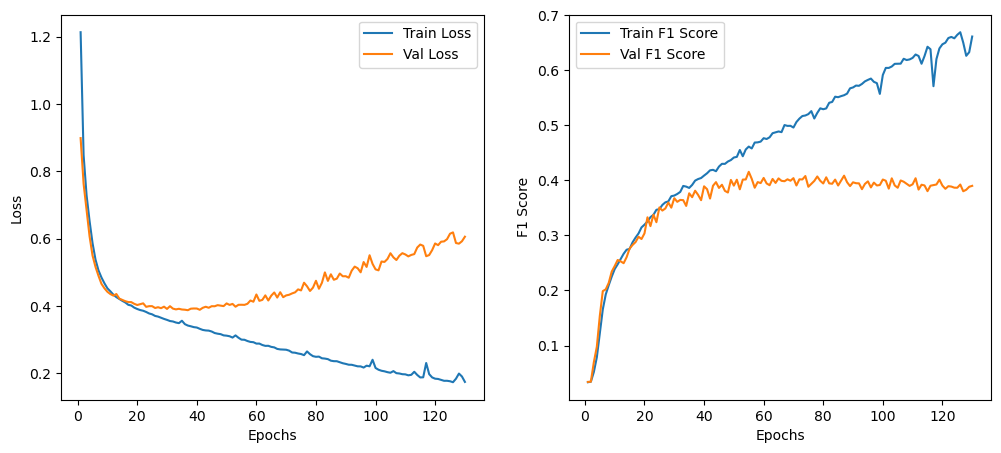

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()